# Blood Cell Detection and Classification
--- 

## 初始化

In [10]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.optim as optim
import torchvision
from torchvision.transforms import v2 as transforms

import os
import tqdm
import shutil
import xml.etree.ElementTree as ET
import xmltodict

from tools import imagenette_dataset, train_model, evaluate_model
from models import Net, LeNet_5

下載資料集

In [2]:
if not os.path.exists('./blood-cells/'):
    path = kagglehub.dataset_download('paultimothymooney/blood-cells')
    print(f"Dataset downloaded to {path}")
    d = './blood-cells/'
    if os.path.isdir(path):
        shutil.copytree(path, d)
    print(f"Dataset setup completed.")
else:
    print("Dataset already exists.")

Dataset already exists.


In [3]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
	device = torch.device("cuda:0")
	print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
	device = torch.device("cpu")
	print("Using CPU")

Using CPU


## Classification

資料集設定

In [4]:
DATA_DIR = "./blood-cells/dataset2-master/dataset2-master/images/"

# Data transformations
data_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = imagenette_dataset(
    f"{DATA_DIR}/TRAIN", transform=data_transform)
val_dataset = imagenette_dataset(
    f"{DATA_DIR}/TEST_SIMPLE", transform=data_transform)
test_dataset = imagenette_dataset(
    f"{DATA_DIR}/TEST", transform=data_transform)

c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


載入資料

In [5]:
os_type = os.name
print("OS type:", os_type)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True,
    num_workers=4 if os_type == 'nt' else 0)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16,
    num_workers=4 if os_type == 'nt' else 0)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16,
    num_workers=4 if os_type == 'nt' else 0)

OS type: nt


資料樣本

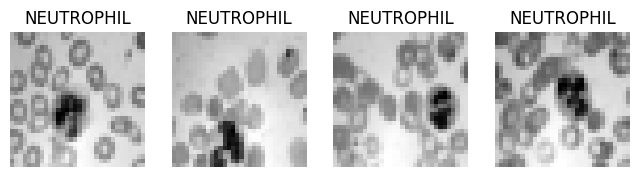

In [6]:
# Plot some samples
fig, axes = plt.subplots(1, 4, figsize=(8, 8))
for i in range(4):
    idx = np.random.randint(len(val_dataset))
    image, label = val_dataset[idx]
    label_name = val_dataset.idx_to_class[label]
    if image.shape[0] == 3:
        image = image.squeeze().permute(1, 2, 0)  # CxHxW to HxWxC for plotting
        cmap = None
    if image.shape[0] == 1:
        image = image.squeeze()  # HxW for grayscale images
        cmap = 'gray'
    axes[i].imshow(image, cmap=cmap)
    axes[i].set_title(f"{label_name}")
    axes[i].axis('off')
plt.show()

模型設定

In [7]:
# Instantiate the model
model = LeNet_5(input_size=32*32, output_classes=len(train_dataset.class_to_idx))
model = model.to(device)
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

LeNet_5(
  (cnn_model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=1024, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=4, bias=True)
  )
)


模型訓練

In [8]:
n_epochs = 20
pbar = tqdm.tqdm(total=n_epochs)
train_logs = []
val_logs = []
for epoch in range(n_epochs):
    # 1. Train the model for one epoch
    train_loss, train_accuracy = train_model(model, train_dataloader, optimizer, device)
    # 2. Evaluate the model on validation set
    val_loss, val_accuracy = evaluate_model(model, val_dataloader, device)
    # 3. Step the scheduler
    scheduler.step()
    
    train_logs.append((train_loss, train_accuracy))
    val_logs.append((val_loss, val_accuracy))
    pbar.set_description(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    pbar.update(1)
pbar.close()

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

儲存模型

In [ ]:
MODEL_DIR = './model/'
torch.save(model.state_dict(), f'{MODEL_DIR}/LeNet-5_model.pth')
# del model

載入模型

In [ ]:
model = Net(input_size=128*128, output_classes=len(train_dataset.class_to_idx))
model.load_state_dict(torch.load(f'{MODEL_DIR}/LeNet-5_model.pth'))
model = model.to(device)

輸出結果

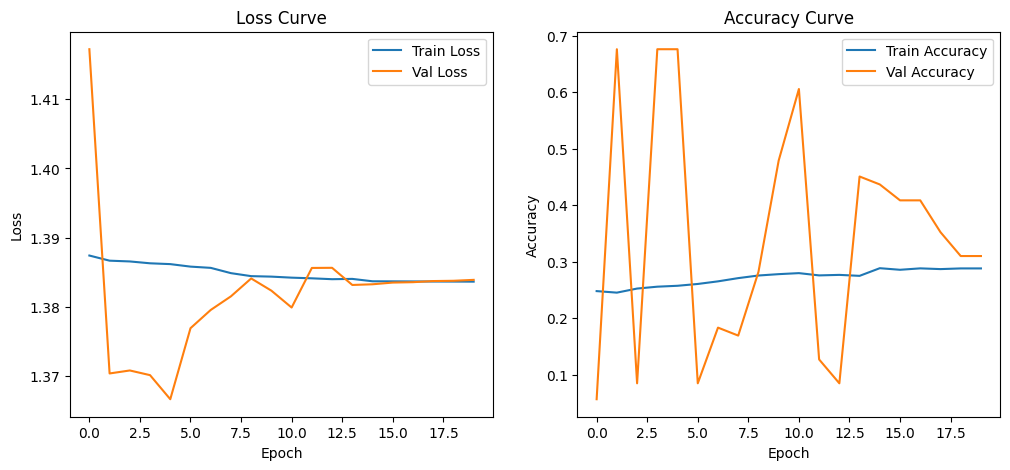

In [ ]:
train_losses, train_accuracies = zip(*train_logs)
val_losses, val_accuracies = zip(*val_logs)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

## Detection

資料轉譯
> YOLO 的資料格式為 .txt

In [18]:
class_mapping = {
    "RBC": 0,
}

def convert_annotation(xml_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(xml_folder):
        if not filename.endswith('.xml'): continue
        
        with open(os.path.join(xml_folder, filename), 'r') as f:
            data = xmltodict.parse(f.read())
        
        image_width = int(data['annotation']['size']['width'])
        image_height = int(data['annotation']['size']['height'])
        
        yolo_lines = []
        objects = data['annotation'].get('object', [])
        if not isinstance(objects, list): objects = [objects]
        
        for obj in objects:
            name = obj['name']
            if name not in class_mapping:
                print(f"Skipping unknown class: {name}")
                continue
            
            class_id = class_mapping[name]
            
            # 讀取邊界框
            bndbox = obj['bndbox']
            xmin = int(bndbox['xmin'])
            ymin = int(bndbox['ymin'])
            xmax = int(bndbox['xmax'])
            ymax = int(bndbox['ymax'])
            
            # 轉換為 YOLO 格式 (center_x, center_y, width, height) -> (0~1)
            x_center = ((xmin + xmax) / 2) / image_width
            y_center = ((ymin + ymax) / 2) / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height
            
            yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}")
            
        # 存成同名的 .txt 檔案
        txt_filename = filename.replace('.xml', '.txt')
        with open(os.path.join(output_folder, txt_filename), 'w') as out_f:
            out_f.write('\n'.join(yolo_lines))


convert_annotation("./blood-cells/dataset-master/dataset-master/annotations", "./blood-cells/dataset-master/labels")

YOLO 模型訓練

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt') 
model.train(data='data.yaml', epochs=50, imgsz=640)
model.save('./model/blood_cell_yolov8n.pt')

os.remove('yolov8n.pt')

Ultralytics 8.3.230  Python-3.12.5 torch-2.9.1+cpu CPU (AMD Ryzen AI 9 HX 370 w/ Radeon 890M)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:650: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:694: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:694: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
c:\Users\Sam\AppData\Local\Programs\P

                   all        366          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels

1 epochs completed in 0.020 hours.
Optimizer stripped from C:\Users\Sam\\\\\\\Code\runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\Sam\\\\\\\Code\runs\detect\train3\weights\best.pt, 6.2MB

Validating C:\Users\Sam\\\\\\\Code\runs\detect\train3\weights\best.pt...
Ultralytics 8.3.230  Python-3.12.5 torch-2.9.1+cpu CPU (AMD Ryzen AI 9 HX 370 w/ Radeon 890M)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 1.1it/s 11.0s1.0s


c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:650: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:694: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:694: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
c:\Users\Sam\AppData\Local\Programs\P

                   all        366          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels
Speed: 0.5ms preprocess, 25.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to C:\Users\Sam\\\\\\\Code\runs\detect\train3


資料樣本

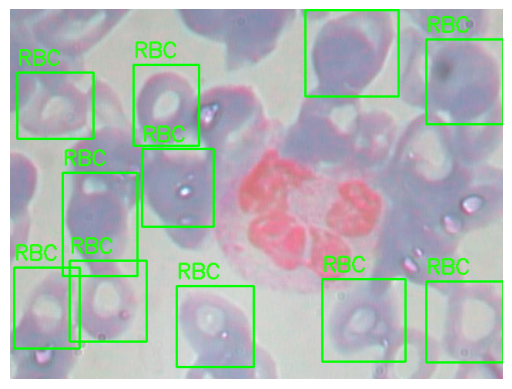

In [20]:
image_dir = './blood-cells/dataset-master/dataset-master/JPEGImages/'
annot_dir = './blood-cells/dataset-master/dataset-master/Annotations/'

image_index = '00000'
annotation_path = annot_dir + f'BloodImage_{image_index}.xml'
original_image_path = image_dir + f'BloodImage_{image_index}.jpg'

plt.axis('off')

# Original Image
img = cv2.imread(original_image_path)

# Draw Bounding Boxes
tree = ET.parse(annotation_path)
root = tree.getroot()
obj_count = len(root.findall('object'))
for obj in root.findall('object'):
    bbox = obj.find('bndbox')
    name = str(obj.find('name').text)
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    cv2.putText(img, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(img)

載入並使用模型


image 1/1 c:\Users\\\\\\\\Code\blood-cells\dataset-master\dataset-master\JPEGImages\BloodImage_00000.jpg: 480x640 (no detections), 32.7ms
Speed: 0.9ms preprocess, 32.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


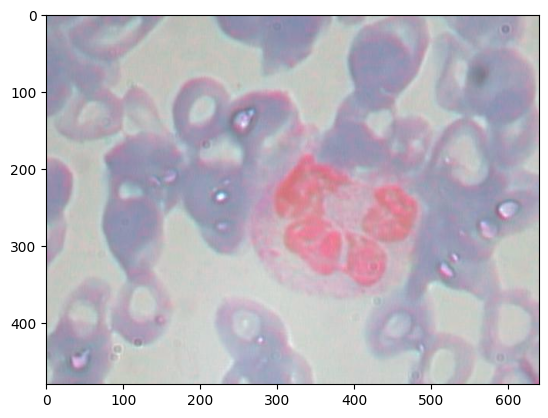

In [21]:
detection_model = YOLO('./model/blood_cell_yolov8n.pt')
original_img = cv2.imread(original_image_path)
results = detection_model(original_image_path)

for result in results:
    boxes = result.boxes
    for box in boxes:
        
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(original_img, (x1, y1), (x2, y2), (255, 255, 0), 2)

plt.imshow(original_img)